# Laplacian Pyramid

#### Problem Statement.

In this problem, given an image we compute a 5 level laplacian pyramid for the image and view the image at each level.

We shall use a 3 x 3 Gaussian filter for smoothing.

Here are the general steps that we shall follow for generating the Laplacian pyramid:
1. Apply Gaussian filtering on the original image of size M x N. This will result in smoothing of sharp edges, and results in a blur image of size M/2 x N/2, due to downsampling.
2. Upsample the blur image to size M x N.
3. Subtract the blur image from the original image, to get the Laplacian at level 0.
4. For next iteration, replace the original image with blur image obtained in step 1 of size M/2 x N/2.

Repeat the above process 5 times for generating a 5 level Laplacian pyramid.

In the next step, we try to reverse the effects of Gaussian smoothing and try to reconstruct the original image. This is done as follows:
1. Take the gaussian blur image at the top of Gaussian pyramid (the one obtained in the last iteration of constructing Laplacian filter.) Let the size of this blur image be X x Y.
2. The size of image at the top(last) of Laplacian pyramid will be 2X x 2Y. Upsample the gaussian blur image to size 2X x 2Y.
3. Add the Laplacian at the top to the upsampled image.
4. This will infact result in the image in Gaussian Pyramid at level top - 1. Use this image as input to step 1 and keep repeating until the bottom of the Laplacian pyramid.
5. At the end of iterations, we shall have our original image back.


### Hypothesis: We should be able to construct the exact original image back. This implies, the Mean Square Error between the original image and the image obtained by reconstruction must be 0.

Let us try and verify the above hypothesis.

In [1]:
% matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

Let us import a few libraries for reading image, array operations and for visualising the output.

Next, let us define our Gaussian Kernel function, which we shall use for smoothing.

In [2]:
# gaussian_kernel_5x5 = (1.0/256)*np.array([[1, 4,  6,  4,  1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4,  6,  4,  1]])
gaussian_kernel = (1.0/16)*np.array([[1, 2, 1],[2,4,2],[1,2,1]])

Let us define a few basic operation functions, which shall help us get started.

First, preprocessing the image into appropriate size. If we have an odd sized image, we convert it into an even sized image.

In [3]:
def preprocess_odd_images(img):
    M, N = img.shape[:2]
    if M % 2 == 1 and N % 2 == 1:
        return img[1:][1:]
    elif M%2 == 1:
        return img[1:][:]
    elif N%2 == 1:
        return img[:][1:]
    else:
        return img

In [4]:
# Function to handle convolution of two images(matrices). Defining this as a general function helps 
# us in making repeated calls to the function in future.
def convolve(f, g):
    vmax = f.shape[0]
    wmax = f.shape[1]
    smax = g.shape[0]
    tmax = g.shape[1]
    smid = smax // 2
    tmid = tmax // 2
    xmax = vmax + 2*smid
    ymax = wmax + 2*tmid
    # Allocate result image.
    h = np.zeros([xmax, ymax], dtype=f.dtype)
    # Do convolution
    for x in range(xmax):
        for y in range(ymax):
            # Calculate pixel value for h at (x,y). Sum one component
            # for each pixel (s, t) of the filter g.
            s_from = max(smid - x, -smid)
            s_to = min((xmax - x) - smid, smid + 1)
            t_from = max(tmid - y, -tmid)
            t_to = min((ymax - y) - tmid, tmid + 1)
            value = 0
            for s in range(s_from, s_to):
                for t in range(t_from, t_to):
                    v = x - smid + s
                    w = y - tmid + t
                    value += g[smid - s, tmid - t] * f[v, w]
            h[x, y] = value
    return h

In [5]:
# Function for upsampling of gaussian blur images.
def interpolate(image):
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return convolve(image_up, 4*gaussian_kernel)

In [6]:
# Functions to plot our results
def plot_input(img, title):
    plt.imshow(img, cmap = 'gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

def sub_plot(img1, img2, img3, title):
    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(img1, cmap = 'gray')
    plt.subplot(132)
    plt.imshow(img2, cmap = 'gray')
    plt.subplot(133)
    plt.imshow(img3, cmap = 'gray')
    plt.show()

In [7]:
# Often the convolved image is not of the same size as the input image. The following function takes care of the 
# appropriate padding to ensure images are of same size before addition of subtraction.
def handle_img_padding(img1, img2):
    M1, N1 = img1.shape[:2]
    M2, N2 = img2.shape[:2]
    padding_x = np.abs(M2 - M1)/2
    padding_y = np.abs(N2 - N1)/2
    img2 = img2[padding_x:M1+padding_x, padding_y: N1+padding_y]
    return img2

In [8]:
# Given two matrices as input, the following function computes the minimum squared error(MSE) of the two matrices.
def min_sqr_err(mat1, mat2):
    min_sq = 0
    M, N = mat1.shape[:2]
    for i in range(M):
        for j in range(N):
            min_sq += np.square(mat1[i][j] - mat2[i][j])
    return min_sq

In [9]:
# Function to perform Gaussian filtering on a given image. It convolves a given image with the Gaussian kernel 
# defined above and performs downsampling of the result.
def gaussian_pyramid(image):
    image_blur = convolve(image, gaussian_kernel)
    return image_blur[::2, ::2]

In [10]:
# Function to generate Gaussian and Laplacian pyramids using the method described above. Returns the generated
# Gaussian pyramid and Laplacian pyramid.
def create_gaussian_laplacian_pyramids(image, level):
    G = [image]
    L = []
    while level > 0:
        level -= 1
        image_blur = gaussian_pyramid(image)
        G.append(image_blur)
        expanded_img = interpolate(image_blur)
        if image.shape[:2] != expanded_img.shape[:2]:
            expanded_img = handle_img_padding(image, expanded_img)
        laplacian = image - expanded_img
        L.append(laplacian)
        image = image_blur
    return G, L

In [11]:
# Function to reconstruct original image using the computed Gaussian and Laplacian filters. 
# The function follows the steps described above for reconstruction of the image.
def reconstruct_original_img(G, L):
    reconstructed_images = []
    for i in range(len(G)-1 , 0, -1):
        expanded_img = interpolate(G[i])
        if expanded_img.shape[:2]!= L[i-1].shape[:2]:
            resized_img = handle_img_padding(L[i-1], expanded_img)
        reconstructed_images.append(resized_img + L[i-1])
        sub_plot(expanded_img, L[i-1], resized_img + L[i-1], "Levels" + str(i))
    return reconstructed_images

Now that we have all the necessary methods defined, let us approach the problem.

First let us load an image of our choice, preprocess it and visualize it as 8-bit grayscale image.

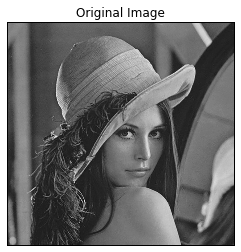

In [12]:
original_img = cv2.imread('./lena_sodberg.jpg', 0)
original_img = preprocess_odd_images(original_img)
plot_input(original_img, 'Original Image')

In [13]:
M,N = original_img.shape[:2]
print "Dimensions of given image are: ", M, N

Dimensions of given image are:  728 740


In [14]:
pyramid_levels = 6

## Part A.

### Now let us generate the Gaussian and laplacian pyramids.

In [15]:
gaussian_pyramid, laplacian_pyramid = create_gaussian_laplacian_pyramids(original_img, pyramid_levels)

Let us visualise different levels in the Laplacian pyramid.

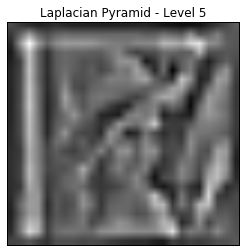

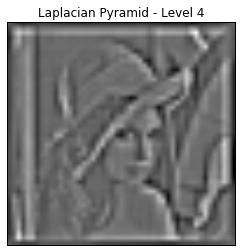

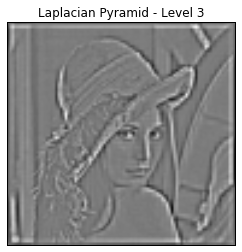

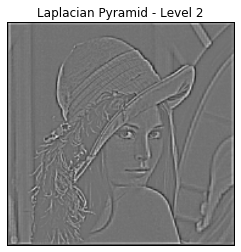

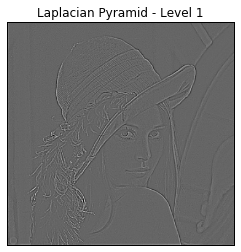

In [16]:
for i in range(len(laplacian_pyramid)-1, 0, -1):
    plot_input(laplacian_pyramid[i], 'Laplacian Pyramid - Level '+ str(i))

Now similarly, let us view the Gaussian pyramid of blur images generated. At each step, we can see the image blurring. The first level of the Gaussian pyramid is the original image itself.

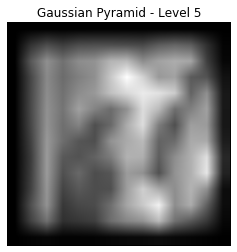

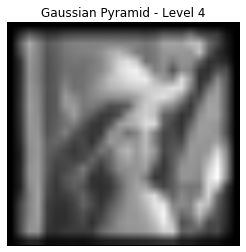

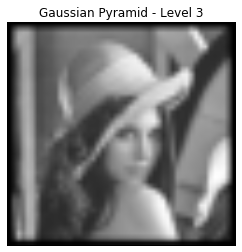

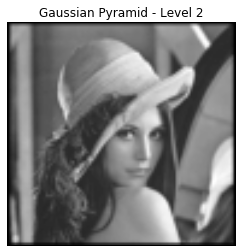

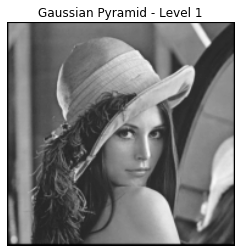

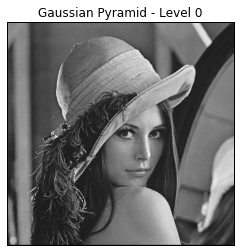

In [17]:
for i in range(len(gaussian_pyramid)-1, 0, -1):
    plot_input(gaussian_pyramid[i], 'Gaussian Pyramid - Level '+ str(i-1))

## Part B.
### Image Reconstruction

Now using the Laplacian pyramid and the blur image, let us try and reconstruct the original image.

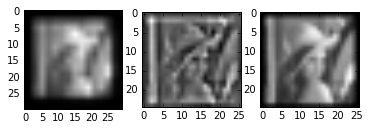

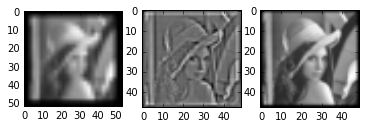

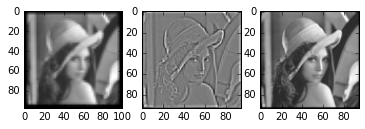

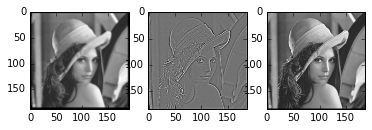

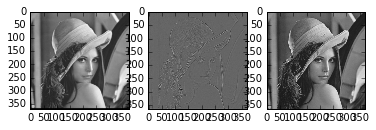

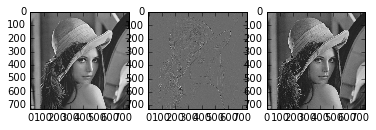

In [18]:
reconstructed_images = reconstruct_original_img(gaussian_pyramid, laplacian_pyramid)

### At each step, we can verify that:

### Gaussian_Pyramid[i] + Laplacian_Pyramid[i] = Gaussian_Pyramid[i-1]

#### Finally, we have Gaussian_Pyramid[0], which infact is the original image.

To verify if we actually have obtained the original image, let us compute the mean squared error, between the 
reconstructed image and the original image.

## Part C.
### MSE Computation

In [21]:
final_image = reconstructed_images[-1]
print "Minimum Squared Error (MSE) : ", min_sqr_err(original_img, final_image)

 Minimum Squared Error (MSE) :  0.0


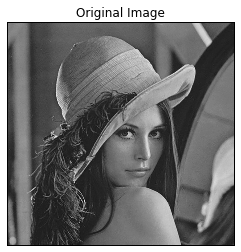

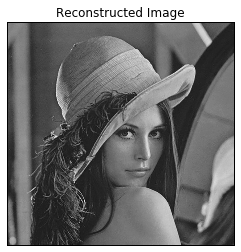

In [23]:
plot_input(original_img, 'Original Image')
plot_input(final_image, 'Reconstructed Image')

## Part D.
### Conclusion

The reconstructed image is infact the original image, as verified by the value of MSE, which is 0.
The MSE is 0, because at every level, where Gaussian pyramid(low pass filter) removes the high frequencies, the Laplacian pyramid stores just these high frequencies in the image. 
Once we have a blurred image at any level in the Gaussian pyramid, and the corresponding Laplacian pyramid, we can reconstruct the original image by successive addition of higher frequency components at different levels.
Due to this property of the Laplacian pyramids, it is used for ***Image Compression***.